# Analyzing Meridians Artblocks

This notebook analyzes the Meridian Art Blocks collection with a focus on their traits and the prices they can realize. [Visit the repository](https://github.com/ymyke) for more notebooks on other projects, to use the code, or to contribute.

Important: This notebook uses [Plotly](https://plotly.com/python/) mostly to visualize data. Plotly charts won't be rendered in Githubs notebook viewer. So please [view this notebook on nbviewer](https://nbviewer.org/github/ymyke/niftylytics/blob/main/meridians.ipynb) (or on your local installation after cloning the repo). Note that nbviewer caches notebooks and sometimes takes a long time to pick up a new version.

On the upside, all the Plotly charts are interactive. You can zoom, hover, pan, etc. Zooming is especially important due to the outliers in some the data so you can zoom in on the interesting parts.

In [1]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Get the Meridians

Note that this takes a couple of minutes. Also note the timestamp below,
that is when the information was last retrieved.

In [2]:
import datetime
from opensea import ARTBLOCK_CONTRACT, retrieve_assets

MERIDIAN_IDS = list(range(163000000, 163001000))
assets = retrieve_assets(token_ids=MERIDIAN_IDS, contract=ARTBLOCK_CONTRACT)
print(datetime.datetime.now())

.................................................. -- All 1000 assets retrieved.
2021-10-14 22:12:28.265832


## Build a dataframe

In [3]:
import numpy as np
import pandas as pd
from helpers import turn_assets_into_df
df, traits = turn_assets_into_df(assets)
hoverdata = [ "Name", *traits, "Probscore"]

In [4]:
assert set(df.LPsymbol.unique()) == set(["ETH", "WETH", np.nan]), """
This sheet does not do currency conversion at the moment and therefore 
assumes all prices are in (W)ETH. But there are more symbols in the input 
data which would lead to apples being compared to ranges below. Aborting.
"""

## How many pieces have a last price on OpenSea?

In [5]:
print(f"{df[~df.Lastprice.isna()].shape[0] / df.shape[0]:.0%}")


79%


## How are prices evolving over time?

Note that this only takes into account the last sale of each piece.

In [6]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 8)
pd.plotting.register_matplotlib_converters()

fig = px.scatter(df, x="LPdate", y="Lastprice", hover_data=hoverdata)
fig.show()

## Price levels today

In [39]:
fig = px.histogram(df, x="Lastprice", marginal="box", hover_data=hoverdata)
fig.show()

## How frequent are the different traits?

In [8]:
for trait in traits:
    display(
        pd.DataFrame(df[trait].value_counts(normalize=False, sort=True, ascending=True)).transpose()
    )


,Monochrome,Trichrome,Polychrome,Duochrome
Chromaticity,127,226,295,352


,High,Gradual,Low,Standard
Frequency,57,213,239,491


,Glacier,Cave,Mesa,Shore,Prairie,Marsh,Ridge,Delta,Atoll,Volcano,...,Canyon,Archipelago,Peninsula,Reef,Dune,Cove,Fjord,Moraine,Oasis,Other
Palette,14,15,15,17,17,17,18,18,19,19,...,21,21,21,22,22,23,25,26,27,585


,Variable,Uniform
Structure,192,808


,Prime,Topographic,Charcoal,Newsprint,Invert,Lino,Screenprint,Watercolour,Gilded,Polarized,Procedural,Gouache,Prismatic,Paletted
Style,8,8,9,12,13,20,21,22,27,32,60,99,262,407


,Far,Medium,Close
Zoom,326,327,347


## How much do people pay for the different traits?

In [40]:
for trait in traits:

    fig = go.Figure()
    for traitvariant in (
        df.groupby(trait).median().sort_values("Lastprice", ascending=False).index
    ):
        fig.add_trace(
            go.Box(
                y=df[df[trait] == traitvariant].Lastprice.values,
                name=traitvariant,
                boxpoints="all",
                jitter=0.2,
                whiskerwidth=0.2,
                marker_size=2,
                line_width=1,
            )
        )
    fig.update_layout(title=trait)
    fig.show()


**Some observations:**

* Chromaticity: Highest prices for monochrome, approx. same level for duochrome and trichrome, lowest prices for polychrome.
* Frequency: No clear tendencies. Low seems to be clearly performing worst in terms of price; the other three are similar, on a slightly higher level.
* Palette: High variance and low sample size, therefore no clear tendencies. Peninsula seems to be performing somewhat consistently better than for example Esker or Dune.
* Structure: Irrelevant wrt to price level.
* Style: The most seldom styles obviously have the largest variance, and they also command the highest prices. Huge variance and outliers for Charcoal and Prime. Prismatic the style with consistently lowest prices.
* Zoom: Not much differentiation.

Overall, **Style** has the biggest impact on price, with additional impact added by **Chromaticity** and **Palette**. The other traits (Frequency, Structure, Zoom) don't make a lot of a difference.


## Digging deeper into Palette and Chromaticity traits

Digging deeper into Palette, we find that the only traits that use the different palettes are Paletted and Prime. Thus, for most Styles, the Palette is irrelevant because there is only one:

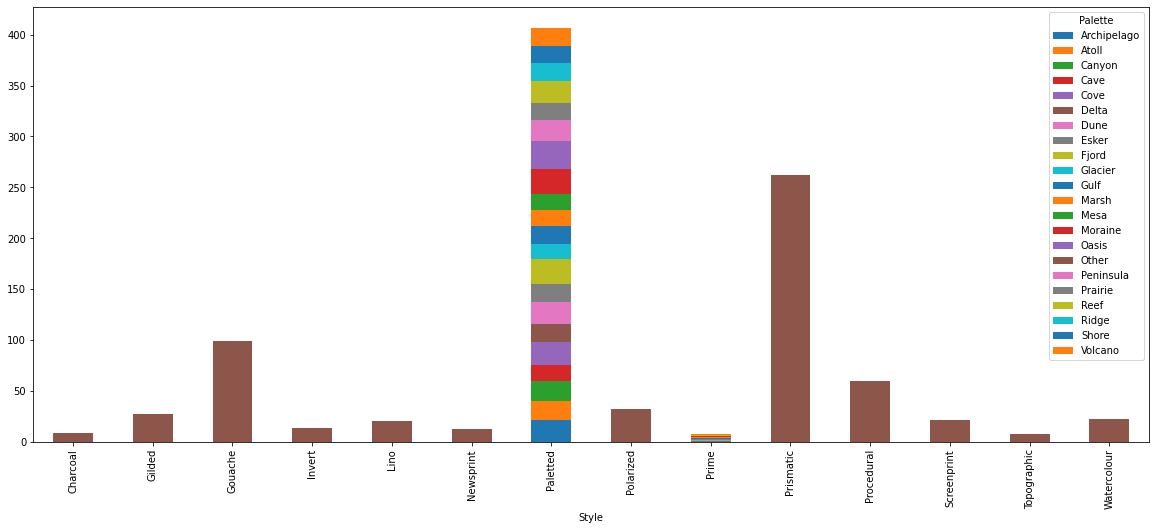

In [10]:
_ = pd.crosstab(df.Style, df.Palette).plot(kind="bar", stacked=True)

The situation is similar, albeit a bit more nuanced with the Chromaticity trait. Many styles, espcially the seldom onces, only have one type of Chromaticity, Monochrome:

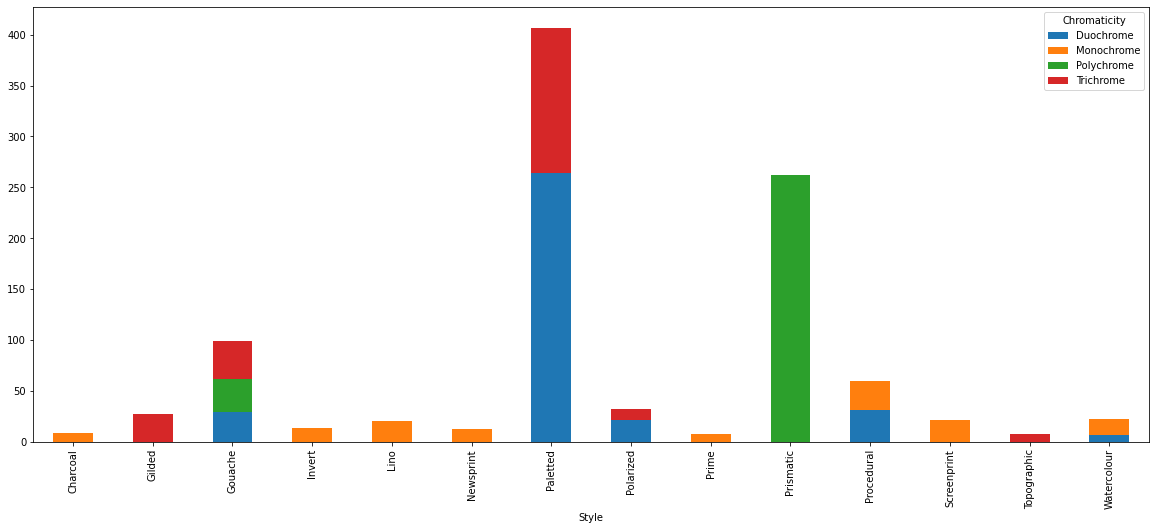

In [11]:
_ = pd.crosstab(df.Style, df.Chromaticity).plot(kind="bar", stacked=True)

Looking at those Styles that have several variants of Chromaticity, we see that Chromaticity makes some difference in certain cases, e.g., Duochrome would be the preferred Chromaticity for both Watercolour and Polarized from a pure price perspective:

In [41]:
fig = px.box(df[df.Style.isin(["Gouache", "Paletted", "Polarized", "Procedural", "Watercolour"])], x="Style", y="Lastprice", color="Chromaticity")
fig.show()

## Probscore as a simple unified metric to predict prices

The Probscore metric is simply the product of the probabilities of the different traits of a piece. There is currently not much value in that metric. While only the lowest probabilities are able to command the very high outlier prices, overall correlation between Probscore and Lastprice remains low:

In [42]:
fig = px.scatter(df, x="Probscore", y="Lastprice")
fig.show()
df[["Probscore", "Lastprice"]].corr()

,Probscore,Lastprice
Probscore,1.000000,-0.135835
Lastprice,-0.135835,1.000000


# Style Frequency as an improved metric

Since style seems to be the most important trait of a Meridian, let's try style frequency as a measure. We'll "turn it around" here so larger numbers mean higher rarity in terms of style. Correlation is much higher than with the generic Probscore.

In [43]:
df["Style Rarity"] = 1 / df["Style"].map(df["Style"].value_counts(normalize=True))
fig = px.scatter(df, x="Style Rarity", y="Lastprice")
fig.show()
df[["Style Rarity", "Lastprice"]].corr()


,Style Rarity,Lastprice
Style Rarity,1.000000,0.491844
Lastprice,0.491844,1.000000


The correlation with Price (i.e., asking price) is much lower, which could either mean
that would-be sellers have misguided expectations or that there is a shift happening
away from Style being the most important trait.

In [48]:
df[["Style Rarity", "Price"]].corr()

,Style Rarity,Price
Style Rarity,1.000000,0.254473
Price,0.254473,1.000000


Displaying Lastprice over time along with Style Rarity as the color encoding, we see
that there has been immediate price raises for the rarest pieces right after launch and
not so much afterwards:

In [45]:
px.scatter(
    df,
    x="LPdate",
    y="Lastprice",
    hover_data=hoverdata,
    color="Style Rarity",
    log_y=False,
)
